In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import glob
import string

from sklearn.model_selection import train_test_split


# Carregar Dados

In [208]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_nacional_iguacu.csv',
 '../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/museu_imperial.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/jardim_botanico.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/parque_jalapao.csv',
 '../archive/hopi_hari.csv',
 '../archive/beto-carreiro-sc.csv']

In [209]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário são os nomes dos destinos turísticos

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [210]:
dados.keys()
nomes_destinos=list(dados.keys())

# Análise Exploratória - Notas

## Comparativo entre as notas das atrações

In [211]:
#Verificando a existência de entradas nulas
print('Número de entradas nulas para as notas das atrações:')
print('')
for nome in nomes_destinos:
    print(nome+ ' : {}'.format(dados[nome]['nota'].isnull().sum()))

Número de entradas nulas para as notas das atrações:

parque_nacional_iguacu : 0
parque_chapada_dos_veadeiros : 0
museu_imperial : 0
mercado-central-fortaleza-ce : 0
jardim_botanico : 0
aqua-rio-rj : 0
mercado-ver-o-peso-pa : 0
praia-copacabana-rj : 0
elevador_lacerda : 0
pelourinho_ba : 0
museu_arte_sp : 0
praca-3-poderes-br : 0
parque_jalapao : 0
hopi_hari : 0
beto-carreiro-sc : 0


In [212]:
 
def calcular_proporcao_notas(dados):
    '''
    Função exibe o número de votos que atribuiu cada nota e a proporção desse número de votos em relação ao total 
    de votos para a atração selecionada

    input - dicionário com conjunto de dados para cada atração

    '''
    cont=0
    print('Número correpondente a cada atração')
    for i in dados.keys():
        print(str(cont) +'-' +i )
        cont+=1
    
    
    num=None
    while num not in np.arange(0,15):
        try:
            num=input('Selecione a atração (digite o número correpondente a atração desejada ou -1 para sair): ')
            num=int(num)
            if num not in np.arange(0,15):
                raise Exception()
        except:
            if num==-1:
                return None
            print('Entrada Inválida. Digite o número da atração desejada ou -1 para sair')
    nome_atracao=list(dados.keys())[num]
    dados_atracao=dados[nome_atracao]
    notas_atracao=dados_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    print('')
    print('Nome da atração: {}'.format(nome_atracao))
    print('Total de avaliações: {}'.format(notas_atracao['Número_de_Avaliações'].sum()))
    print(notas_atracao)
    

    
                 

In [213]:
proporcao_notas=[]
for destino in nomes_destinos:
    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))
    proporcao_notas+=[[(dados[destino]['nota']==nota).sum() for nota in [1,2,3,4,5]]]
proporcao_notas=pd.DataFrame(proporcao_notas,index=nomes_destinos)
proporcao_notas["Total Avaliações"]=proporcao_notas.sum(axis=1)
proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
proporcao_notas.columns=   ['nota 1(%)',
                            'nota 2(%)',
                            'nota 3(%)',
                            'nota 4(%)',
                            'nota 5(%)',
                             "Total Avaliações"]

In [214]:
proporcao_notas

,nota 1(%),nota 2(%),nota 3(%),nota 4(%),nota 5(%),Total Avaliações
parque_nacional_iguacu,0.001532,0.001892,0.011715,0.126881,0.857980,11097
parque_chapada_dos_veadeiros,0.002203,0.003672,0.021667,0.148366,0.824091,2723
museu_imperial,0.002822,0.005080,0.034994,0.247778,0.709327,7087
mercado-central-fortaleza-ce,0.012190,0.028059,0.194112,0.402254,0.363385,4348
jardim_botanico,0.001403,0.003724,0.050498,0.253458,0.690916,20674
aqua-rio-rj,0.025720,0.048583,0.150750,0.322220,0.452727,4199
mercado-ver-o-peso-pa,0.046576,0.079845,0.222345,0.319379,0.331855,3607
praia-copacabana-rj,0.011091,0.023617,0.117563,0.278314,0.569415,7664
elevador_lacerda,0.026991,0.064808,0.278066,0.317959,0.312176,6743
pelourinho_ba,0.024637,0.040003,0.165692,0.352347,0.417321,11974


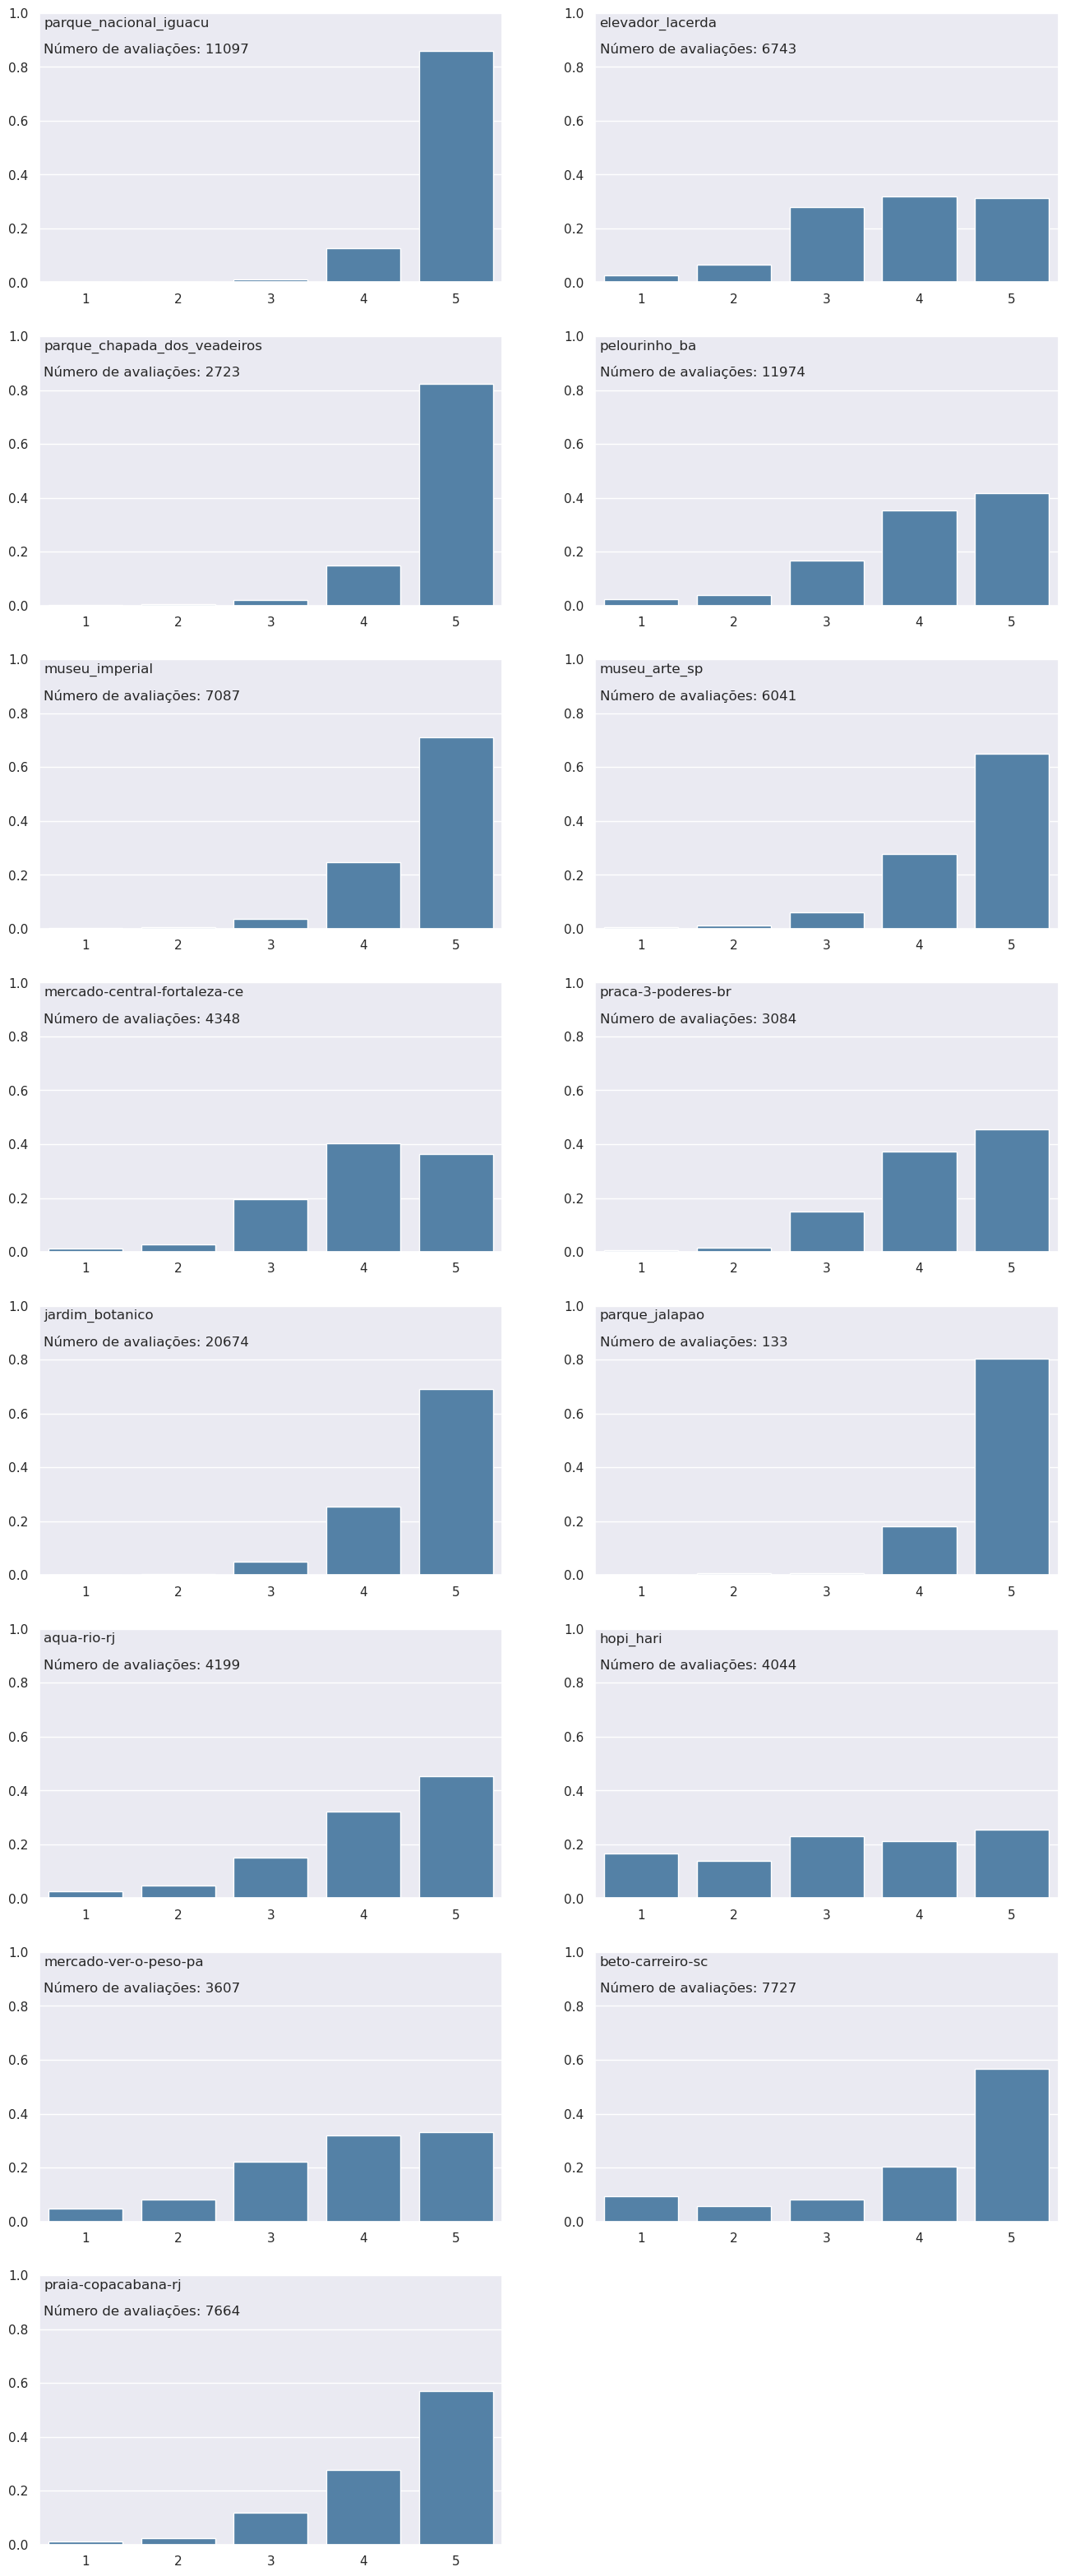

In [215]:
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
sns.set_theme(style='darkgrid')
row_subplot=0
col_subplot=0
plt.title('Proporção das avaliações para cada atração')
for num_destino in range(len(proporcao_notas)):
    destino=proporcao_notas.index[num_destino]
    ax=sns.barplot(x=[1,2,3,4,5],y=proporcao_notas.iloc[num_destino,:5],ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, destino)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(proporcao_notas.loc[destino,'Total Avaliações']))
    ax.set(ylabel=None)
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


In [216]:
#Criação de dataframe com proporção de avaliações negativas, neutras e positivas

#Avaliação negativa - notas 1 e 2
#Avaliação neutra   - nota 3
#Avaliação positiva - notas 4 e 5


pos_neutra_neg=pd.concat((proporcao_notas.iloc[:,:2].sum(axis=1),
                          proporcao_notas.iloc[:,2],
                          proporcao_notas.iloc[:,3:5].sum(axis=1)),axis=1)
pos_neutra_neg.columns=['Negativas(%)',
                        'Neutras(%)',
                        'Positivas(%)']

pos_neutra_neg

,Negativas(%),Neutras(%),Positivas(%)
parque_nacional_iguacu,0.003424,0.011715,0.984861
parque_chapada_dos_veadeiros,0.005876,0.021667,0.972457
museu_imperial,0.007902,0.034994,0.957105
mercado-central-fortaleza-ce,0.040248,0.194112,0.765639
jardim_botanico,0.005127,0.050498,0.944375
aqua-rio-rj,0.074303,0.150750,0.774946
mercado-ver-o-peso-pa,0.126421,0.222345,0.651234
praia-copacabana-rj,0.034708,0.117563,0.847730
elevador_lacerda,0.091799,0.278066,0.630135
pelourinho_ba,0.064640,0.165692,0.769668


[[<matplotlib.axis.YTick at 0x7fa85d711250>,

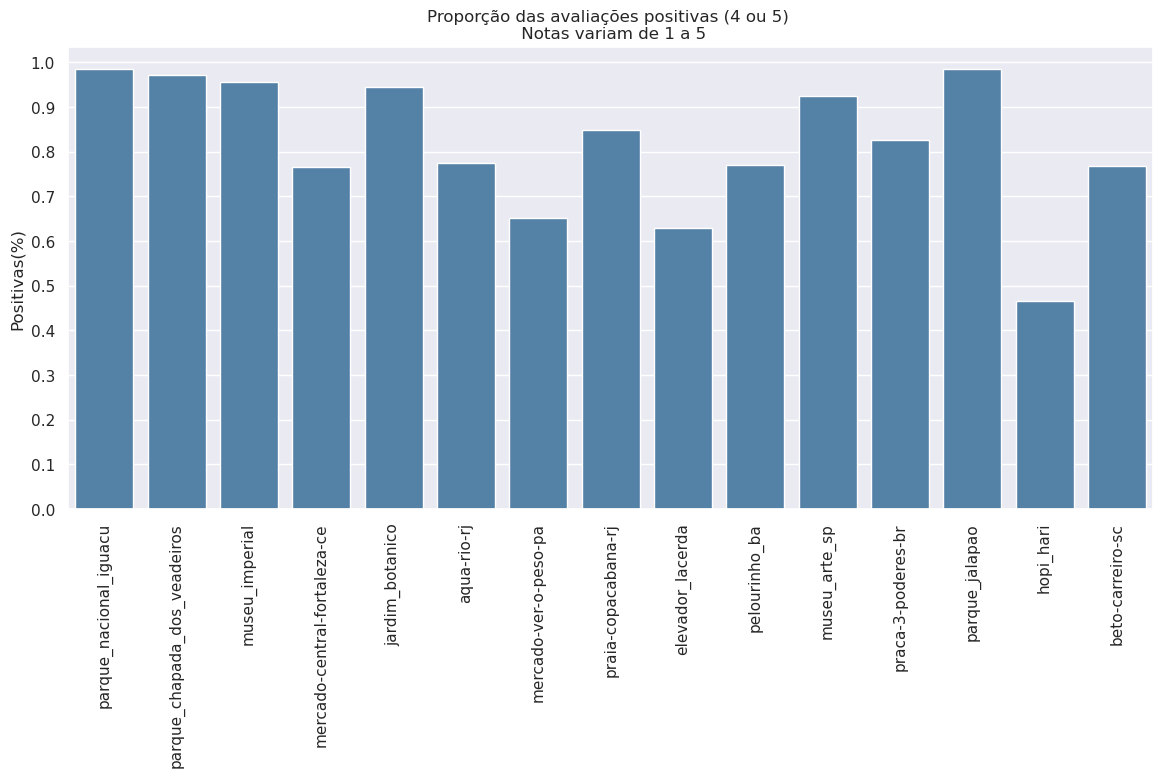

In [217]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações positivas (4 ou 5) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Positivas(%)'],color='steelblue')
g.set(yticks=np.arange(0,1.1,0.1))


[[<matplotlib.axis.YTick at 0x7fa85d7e0490>,

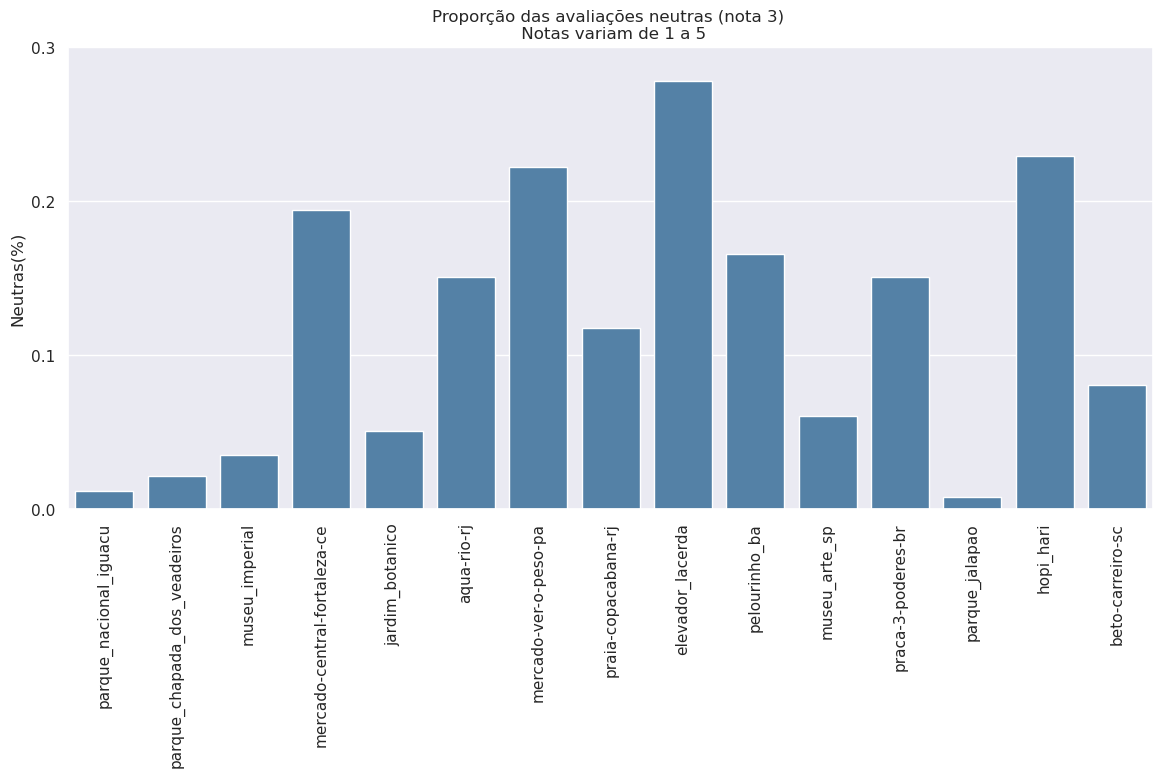

In [218]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações neutras (nota 3) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Neutras(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.4,0.1))

[[<matplotlib.axis.YTick at 0x7fa85d85cd10>,

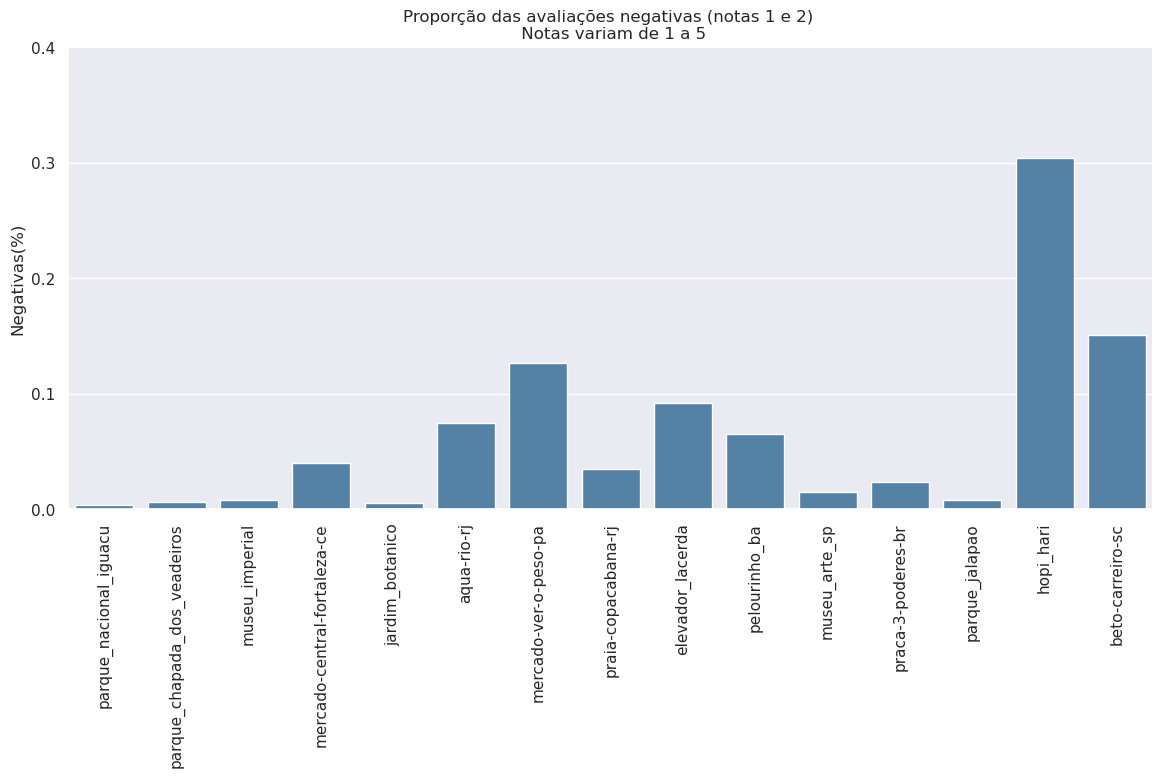

In [219]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações negativas (notas 1 e 2) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Negativas(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.5,0.1))

In [220]:
'''
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
row_subplot=0
col_subplot=0
for atracao in nome_atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])
'''

'\n#Plotar graficos com as proporções das avaliações para cada atração\nfig,axs=plt.subplots(8,2,figsize=(16,40))\nrow_subplot=0\ncol_subplot=0\nfor atracao in nome_atracoes:\n    notas_atracao=dados[atracao]\n    notas_atracao=notas_atracao.groupby(\'nota\').agg(Número_de_Avaliações=(\'nota\',\'count\'))\n    notas_atracao[\'Proporção de Avaliações\']=notas_atracao[\'Número_de_Avaliações\']/notas_atracao[\'Número_de_Avaliações\'].sum()\n    notas_atracao.reset_index(inplace=True)\n    ax=sns.barplot(notas_atracao,x=\'nota\',y=\'Proporção de Avaliações\',ax=axs[row_subplot,col_subplot],color=\'steelblue\')\n    ax.text(-0.45, 0.95, atracao)\n    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao[\'Número_de_Avaliações\'].sum()))\n    ax.set_ylim(0,1)\n    row_subplot+=1\n    if row_subplot>7:\n        row_subplot=0\n        col_subplot=1\nfig.delaxes(axs[7][1])\n'

In [221]:
#Avaliar datas

# Análise Exploratória - Comentários

##  Dataset

In [222]:
#Agrupar os dados de todos os destinos em um mesmo dataframe

for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)

In [223]:
df_dados.head()

,comentario,nota,data,destino
0,"Não tem como explicar, precisa ver de perto a ...",5.0,mar de 2023,parque_nacional_iguacu
1,ótimo lugar! tranquilo e com uma energia marav...,5.0,out de 2022,parque_nacional_iguacu
2,Sensacional! O parque tem uma estrutura inigua...,5.0,fev de 2023,parque_nacional_iguacu
3,É um lugar fantástico para ser visitado. As qu...,5.0,fev de 2023,parque_nacional_iguacu
4,O passeio de barco abaixo das quedas é muito e...,5.0,fev de 2023,parque_nacional_iguacu


In [224]:
x_comentarios=df_dados[['comentario']]
y_notas      =df_dados[['nota']]

In [225]:
#Dataset desbalanceado, são poucas avaliações com 1 ou 2 estrelas
y_notas.value_counts()

nota
5.0     58040
4.0     26829
3.0     10902
2.0      2974
1.0      2400
dtype: int64

In [226]:
#Aproximadamente 57% das avaliações receberam nota 5
y_notas.value_counts()/len(y_notas)

nota
5.0     0.573830
4.0     0.265253
3.0     0.107786
2.0     0.029403
1.0     0.023728
dtype: float64

In [227]:
proporcao_notas_negativas=100*(y_notas.value_counts()[3:].sum())/len(y_notas)
print('Proporção das avaliações com notas 1 ou 2: {}%'.format(proporcao_notas_negativas))

Proporção das avaliações com notas 1 ou 2: 5.313164269118592%


In [228]:
#O conjunto de dados seŕa dividido em treino e teste (70% para treino e 20% para teste)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_comentarios,y_notas,test_size=0.2,stratify=y_notas)

In [229]:
#A separação dos dados de treino e teste foi feito de modo estratificado, de modo que a propoção de amostras de cada classe foi mantida após a separação
y_treino.value_counts()/len(y_treino)
pd.concat((y_notas.value_counts()/len(y_notas),
           y_treino.value_counts()/len(y_treino),
           y_teste.value_counts()/len(y_teste)),axis=1).rename(columns={0:'conjunto total',1:'treino',2:'teste'})

,conjunto total,treino,teste
nota,,,
5.0,0.573830,0.573830,0.573830
4.0,0.265253,0.265250,0.265263
3.0,0.107786,0.107791,0.107766
2.0,0.029403,0.029401,0.029413
1.0,0.023728,0.023728,0.023728


In [230]:
#Numero de amostras de cada nota nos dados de treino e teste
pd.concat((y_treino.value_counts(),y_teste.value_counts()),axis=1).rename(columns={0:'treino',1:'teste'})

,treino,teste
nota,,
5.0,46432,11608
4.0,21463,5366
3.0,8722,2180
2.0,2379,595
1.0,1920,480


In [231]:
#num_col_nota=list(df_dados.columns).index('nota')
#num_col_comentario=list(df_dados.columns).index('comentario')

## Pré-processamento dos comentários

### Removendo a pontuação dos comentários

In [233]:
#Remover pontuação dos comentários usando o método translate

print('Com pontuação: {}'.format(x_treino.iloc[0,0]))
x_treino['comentario']=x_treino['comentario'].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)))
print('Sem pontuação: {}'.format(x_treino.iloc[0,0]))


Com pontuação: Gosto do Beto Carrero, a primeira vez q fomos em um feriado não conseguimos brincar em nada, mas nada mesmo, fila quilométricas , na segunda vez fomos em julho / 2018 dessa vez brincamos, mas em alguns brinquedos. .... já no mês de férias em alta temporada ( JANEIRAO) acho que tivemos sorte,  brincamos em vários brinquedos, minhas filhas ficaram super felizes e assistimos a dois shows .... um das piores coisas q acho lá dentro é o valor alto das refeições e lanches e tb o preço abusivo da garrafinha de água mineral R$ 5.00 e além do mais não tem bebedouro no parque para q possamos encher as garrafinhas, o ideal é levar uma mochila com águas e lanches para fugir daqueles lanches mal preparados.....Pois sinceridade, a comida de lá é horrível. Eles têm q rever isso ...no mais o parque é muito bonito... da próxima vez  não irei em janeiro devido o calor intenso nunca senti tanto calor, logo quando saímos teve uma chuva muito forte e foi noticiado q em Penha havia tido várias

### Análise da frequência que cada palavra aparece nos comentários com cada nota

In [239]:
#Contar o número de vezes que cada palavra aparece nos comentários relativos a cada nota e também o número total de vezes que cada palavra aparece
nota1_count=Counter()
nota2_count=Counter()
nota3_count=Counter()
nota4_count=Counter()
nota5_count=Counter()
total_count=Counter()

In [256]:
for num_row in range(len(x_treino)):
    if y_treino.iloc[num_row,0]==1:
        for palavra in x_treino.iloc[num_row,0].split(" "):
            nota1_count[palavra]+=1
            total_count[palavra]+=1

    elif y_treino.iloc[num_row,0]==2:
        for palavra in x_treino.iloc[num_row,0].split(" "):
            nota2_count[palavra]+=1
            total_count[palavra]+=1

    elif y_treino.iloc[num_row,0]==3:
        for palavra in x_treino.iloc[num_row,0].split(" "):
            nota3_count[palavra]+=1
            total_count[palavra]+=1

    elif y_treino.iloc[num_row,0]==4:
        for palavra in x_treino.iloc[num_row,0].split(" "):
            nota4_count[palavra]+=1
            total_count[palavra]+=1

    else:
        for palavra in x_treino.iloc[num_row,0].split(" "):
            if palavra=='preparadosPois':
                teste=x_treino.iloc[num_row,0]
            nota5_count[palavra]+=1
            total_count[palavra]+=1

In [249]:
#Palavras mais comuns nos comentários com nota 1
nota1_count.most_common()

[('de', 5689),
 ('e', 4905),
 ('que', 4090),
 ('o', 3561),
 ('a', 3399),
 ('não', 2477),
 ('para', 2295),
 ('um', 1948),
 ('com', 1909),
 ('em', 1847),
 ('do', 1796),
 ('parque', 1795),
 ('', 1675),
 ('no', 1652),
 ('é', 1606),
 ('mais', 1215),
 ('uma', 1209),
 ('na', 1087),
 ('os', 994),
 ('brinquedos', 970),
 ('da', 948),
 ('as', 936),
 ('se', 935),
 ('fila', 911),
 ('muito', 809),
 ('por', 801),
 ('filas', 674),
 ('sem', 641),
 ('tem', 629),
 ('ao', 621),
 ('dia', 609),
 ('Não', 605),
 ('mas', 604),
 ('O', 603),
 ('foi', 595),
 ('ir', 585),
 ('pra', 574),
 ('pessoas', 563),
 ('horas', 527),
 ('dos', 491),
 ('estava', 446),
 ('ou', 434),
 ('atrações', 431),
 ('como', 425),
 ('só', 417),
 ('pois', 406),
 ('ser', 398),
 ('lugar', 397),
 ('era', 379),
 ('brinquedo', 376),
 ('nos', 367),
 ('já', 360),
 ('lá', 356),
 ('A', 354),
 ('das', 349),
 ('minha', 341),
 ('até', 329),
 ('2', 325),
 ('mesmo', 322),
 ('nem', 319),
 ('me', 313),
 ('você', 311),
 ('local', 311),
 ('eu', 307),
 ('nada',

In [259]:
#Palavras mais comuns nos comentários com nota 5

nota5_count.most_common()

[('e', 143002),
 ('de', 134564),
 ('a', 100670),
 ('o', 77542),
 ('é', 73696),
 ('para', 64818),
 ('que', 62414),
 ('com', 53816),
 ('do', 52952),
 ('um', 49902),
 ('', 49086),
 ('muito', 47168),
 ('da', 34592),
 ('uma', 33944),
 ('em', 32736),
 ('bem', 29024),
 ('não', 28076),
 ('O', 26620),
 ('no', 26496),
 ('as', 24836),
 ('os', 24086),
 ('parque', 23456),
 ('mais', 21540),
 ('lugar', 19600),
 ('se', 19096),
 ('tem', 19032),
 ('na', 17484),
 ('pena', 16244),
 ('por', 14904),
 ('passeio', 14812),
 ('ao', 14724),
 ('dos', 14698),
 ('mas', 13674),
 ('são', 13442),
 ('lindo', 13202),
 ('local', 12954),
 ('das', 12876),
 ('A', 12164),
 ('conhecer', 11654),
 ('ir', 10796),
 ('como', 10446),
 ('dia', 10272),
 ('visita', 10062),
 ('vale', 9724),
 ('cidade', 9384),
 ('tudo', 9324),
 ('É', 8712),
 ('Vale', 8662),
 ('cuidado', 8644),
 ('ou', 8640),
 ('quem', 8532),
 ('pra', 8438),
 ('Curitiba', 8360),
 ('bom', 8344),
 ('visitar', 8200),
 ('Um', 7972),
 ('todos', 7880),
 ('você', 7814),
 ('pois

In [263]:
#Palavras menos comuns nos comentários com nota 5
nota5_count.most_common()[-1:-20:-1]

[('xxxxxxxxxxx', 2),
 ('lindaVoltarei', 2),
 ('comservado', 2),
 ('transpondo', 2),
 ('tudoComida', 2),
 ('refugiados', 2),
 ('reaisUm', 2),
 ('são10', 2),
 ('preferênciaA', 2),
 ('freepassAlguns', 2),
 ('enooormesSou', 2),
 ('mágicoSó', 2),
 ('FridayO', 2),
 ('rodeam', 2),
 ('frequentamricos', 2),
 ('desconhecemos', 2),
 ('puxe', 2),
 ('horrorizados', 2),
 ('feiura', 2)]

In [ ]:
#Palavras menos comuns nos comentários com nota 1
nota1_count.most_common()[-1:-20:-1]

'''
Comparando os comentários com nota 1 e os comentários com nota 5, é possível notar que as palavras mais frequentes em ambos se repetem, são preposições e artigos como por exemplo e, que , de, do. Esses tipos de palavras aparecem comunmente em todo tipo de frase e não servem para caracterizar um  comentário. Deve-se buscar palavras que aparecem com mais frequência em comentários com determinada nota, espera-se por exemplo que uma palavra como excelente apareça com maior frequência em comentários com nota 5.

Já verificando as palavras que aparecem com menor frequência, verifica-se a ocorrência de palavras com grafia errada e com erros de digitação. Esse tipo de palavra não são úteis para identificar um comentário
e serão portanto removidas.

Para encontrar as palavras que aparecem com maior frequência em comentários com certa nota calcularei a razão entre o número de vezes que um comentário aparece em  comentários com determinada nota
pelo número topal de vezes que a palavra apareceu nos comentário. 



'''

In [253]:
def calcular_razao(counter_nota,counter_total):
    razao=Counter()
    for palavra in counter_nota:
        razao[palavra]=counter_nota[palavra]/counter_total[palavra]
    return razao
    

In [255]:
razao_nota5.most_common()

[('JANEIRAO', 1.0),
 ('preparadosPois', 1.0),
 ('inundações', 1.0),
 ('ventiladoÓtima', 1.0),
 ('colegasPreços', 1.0),
 ('qualidadeAmei', 1.0),
 ('vestuáriosHá', 1.0),
 ('públicoBem', 1.0),
 ('ofertadasFica', 1.0),
 ('definindo', 1.0),
 ('dizir', 1.0),
 ('Caio', 1.0),
 ('lindoagradável', 1.0),
 ('mundo1', 1.0),
 ('Nãp', 1.0),
 ('qualqer', 1.0),
 ('chuveirosquiosque', 1.0),
 ('bicicletaPraia', 1.0),
 ('Ameiiiii', 1.0),
 ('diaestava', 1.0),
 ('visitaConta', 1.0),
 ('Yes', 1.0),
 ('energização', 1.0),
 ('funcionamentoTodas', 1.0),
 ('tampando', 1.0),
 ('Raskabuska', 1.0),
 ('Stat', 1.0),
 ('R100dia', 1.0),
 ('ofertadas', 1.0),
 ('R4000dia', 1.0),
 ('gigantescaLimpeza', 1.0),
 ('milímetro', 1.0),
 ('aprovam', 1.0),
 ('ArquivoA', 1.0),
 ('Erguida', 1.0),
 ('1959', 1.0),
 ('1987', 1.0),
 ('Zeno', 1.0),
 ('Zani', 1.0),
 ('lindeiroso', 1.0),
 ('internacionalmenteLá', 1.0),
 ('animaisvale', 1.0),
 ('Ame', 1.0),
 ('pares', 1.0),
 ('legalPrincipalmente', 1.0),
 ('botando', 1.0),
 ('tenhaCuidado',

'Gosto do Beto Carrero a primeira vez q fomos em um feriado não conseguimos brincar em nada mas nada mesmo fila quilométricas  na segunda vez fomos em julho  2018 dessa vez brincamos mas em alguns brinquedos  já no mês de férias em alta temporada  JANEIRAO acho que tivemos sorte  brincamos em vários brinquedos minhas filhas ficaram super felizes e assistimos a dois shows  um das piores coisas q acho lá dentro é o valor alto das refeições e lanches e tb o preço abusivo da garrafinha de água mineral R 500 e além do mais não tem bebedouro no parque para q possamos encher as garrafinhas o ideal é levar uma mochila com águas e lanches para fugir daqueles lanches mal preparadosPois sinceridade a comida de lá é horrível Eles têm q rever isso no mais o parque é muito bonito da próxima vez  não irei em janeiro devido o calor intenso nunca senti tanto calor logo quando saímos teve uma chuva muito forte e foi noticiado q em Penha havia tido várias inundações no inverno deve ser mais interessante'